In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
import pickle

In [159]:
data,datainfo = tfds.load('malaria',data_dir = '/content/drive/MyDrive/Colab Notebooks/malaria-image-data',with_info = True,as_supervised=True,split=['train'])

In [ ]:
data

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
datainfo

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/content/drive/MyDrive/Colab Notebooks/malaria-image-data/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite

In [ ]:
for i in data[0].take(1):
  print(i)
  break

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
list(data[0].take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [ ]:
#checking some functions
trian_ratio = 0.6
val_ratio = 0.1
test_ratio = 0.1

ex = tf.data.Dataset.range(10)
list(ex.as_numpy_iterator())

print(list(ex.take(int(trian_ratio * len(ex))).as_numpy_iterator()))
list(ex.skip(int(trian_ratio * len(ex))).as_numpy_iterator())

[0, 1, 2, 3, 4, 5]


[6, 7, 8, 9]

In [ ]:
def splitdata(train_ratio,val_ratio,test_ratio,data):
  train = data.take(int(train_ratio * len(data)))

  val = data.skip(int(train_ratio * len(data)))
  val = val.take(int(val_ratio  * len(data)))

  test = data.skip(int((train_ratio +val_ratio) * len(data)))

  return train,val,test



In [ ]:
#checking function if working or not
x,y,z =splitdata(0.6,0,0.2,ex)
print(list(x.as_numpy_iterator()))
print(list(y.as_numpy_iterator()))
print(list(z.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5]
[]
[6, 7, 8, 9]


In [ ]:
train,val,test = splitdata(0.8,0.1,0.1,data[0])

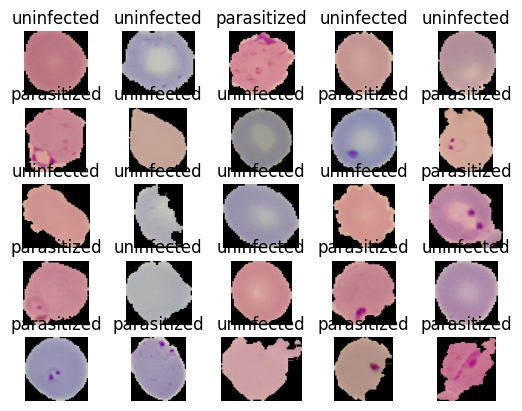

In [ ]:
for i,(image,labels) in enumerate(train.take(25)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(datainfo.features['label'].int2str(labels))
  plt.axis('off')

In [ ]:
#image shape checking it can be any shape
for image,label in train.take(1):
  print(image)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8)


In [ ]:
#resize function and rescale
def resize_image(image,label):
  return tf.image.resize(image,(224,224))/255.0,label

In [ ]:
#all image is being resize in 224 formate
train = train.map(resize_image)
val = val.map(resize_image)
test =  test.map(resize_image)

In [ ]:
train = train.shuffle(buffer_size=8).batch(32).prefetch(tf.data.AUTOTUNE)
val = val.batch(32).prefetch(tf.data.AUTOTUNE)
test = test.batch(1)



In [ ]:
#making lenet model
#refrence = https://en.wikipedia.org/wiki/LeNet
#run this if dont have any saved model (traning takes 25 mins)
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),

    Conv2D(filters=6,kernel_size = 3,strides=1,padding='valid',activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),

    Conv2D(filters = 16,kernel_size = 3,strides=1,padding='valid'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),

    Flatten(),

    Dense(100,activation='relu'),
    BatchNormalization(),
    Dense(10,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid'),

])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
#testing some loss functions
real = [0.0]
pred = [0.1]
bce = BinaryCrossentropy()
bce(real,pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.10536041>

In [ ]:
model.compile(loss = BinaryCrossentropy(),optimizer=Adam(learning_rate=0.01),metrics='accuracy')

In [ ]:

'''hist = model.fit(train,validation_data = val,epochs=35,verbose=1)'''



model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/malaria-image-data/saved-model')
model.summary()

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/tensorflow learn')

In [ ]:
#fil = open('/content/drive/MyDrive/Colab Notebooks/malaria detection/modelhistory.txt','wb')
#pickle.dump(hist.history,fil)

In [ ]:
#hist.history

In [ ]:
#model.summary()

In [ ]:
#hist.history

In [ ]:
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])

In [ ]:
#plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])

In [ ]:
model.evaluate(test)

2756/2756 [==============================] - 28s 5ms/step - loss: 0.6278 - accuracy: 0.9249


[0.627753734588623, 0.9248911738395691]

In [ ]:
def ntol(predict):
  thr = 0.5
  if predict < 0.5:
    return 'Infe'
  return 'Not Infec'

In [ ]:
ntol(model.predict(test.take(1))[0][0])

1/1 [==============================] - 16s 16s/step


'Not Infec'

9/9 [==============================] - 18s 6ms/step


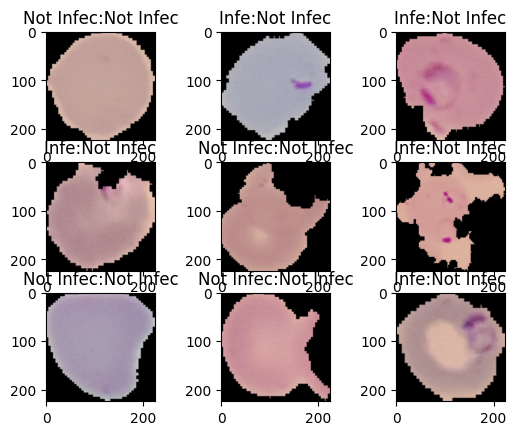

In [ ]:
for i,(image,label) in enumerate(test.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(ntol(label.numpy()[0])) + ':'+str(ntol(model.predict(test.take(9))[0][0])))

In [ ]:
test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>